### Description: Predict sales prices and practice feature engineering. Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. This dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

kaggle competitions download -c house-prices-advanced-regression-techniques

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, I am trying to predict the final price of each home.

This notebook is inspired by a kaggle noteook- COMPREHENSIVE DATA EXPLORATION WITH PYTHON on the same dataset by Pedro Marcelin.
https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python

There will be five steps in our EDA--
1. Understanding the problem and variables
2. Univariate study- about the dependent variable
3. Multivariate study- relation between dependent and independent variables
4. Basic Cleaning- handling missing data, outliers and categorical variables
5. Test assumptions for multivariate techniques


#### Importing libraries and data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.shape

(1460, 81)

In [4]:
test.shape

(1459, 80)

### 1.) Knowledge is Power

In order to understand the problem and variables(which are a lot in this case) we need to do a simple task which can be time consuming.
Create an excel sheet with six columns: 
* Variable_name, Type_of_variable (numerical or categorical)
* Segment (Building- if variable is related to the physical characteristics of the building, Space- variable that reports space properties of the house or Location- a variable that gives information about the place where the house is located)
* Expectation(how much it can influence the SalePrice- High, Medium or Low)
* Conclusion 
* Comments

Fill every column for each variable(it will take long time but it is worth it). After doing that we will look at the variables with 'High' expectation and roll out some scatter plots between those variables and SalePrice.

When I did this exercise I ended up with the same conclusion as Pedro OverallQual, YearBuilt, TotalBsmtSf andGrLivArea prooved to be important variables. Lets go ahead and see if that's true.

#### Analysing 'SalePrice'

In [5]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

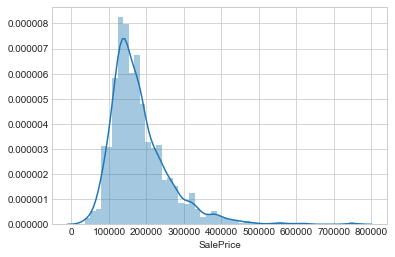

In [6]:
#histogram
sns.distplot(train['SalePrice']);

In [7]:
#Skewness and Kurtosis
print('Skewness: %f' %train['SalePrice'].skew())
print("Kurtosis: %f" %train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


The histogram is not normal and data has positive skewness and long tail (shown by high kurtosis value

#### Let's plot few graphs now to see the realtionship between some numerical variables and SalePrice

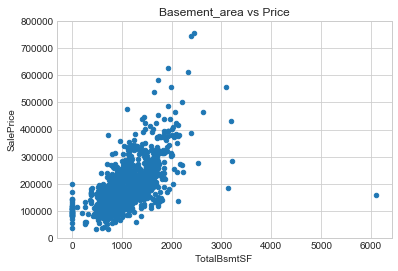

In [8]:
#scatter plot between SalePrice and TotalBsmtSF
train.plot.scatter(x= 'TotalBsmtSF' , y= 'SalePrice',  ylim=(0,800000))
plt.title('Basement_area vs Price')  
plt.xlabel('TotalBsmtSF')  
plt.ylabel('SalePrice')
plt.show()

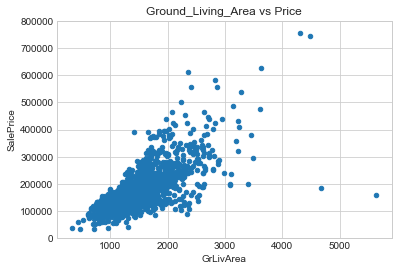

In [9]:
train.plot.scatter(x= 'GrLivArea' , y= 'SalePrice', ylim=(0,800000))
plt.title('Ground_Living_Area vs Price')  
plt.xlabel('GrLivArea')  
plt.ylabel('SalePrice')
plt.show()

There is a positive linear relationship between ground living area, basement area and Sale price. But TotalBsmtSF have a stronger linear or mabe exponentail relationship.

#### Relationship with categorical features

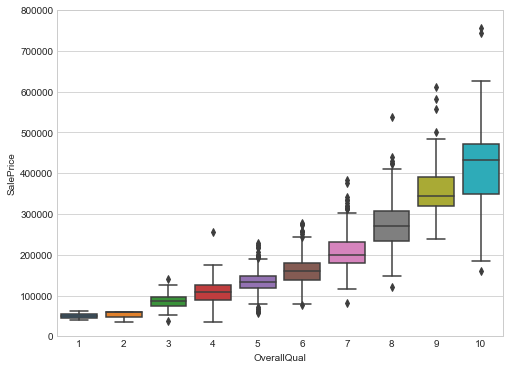

In [10]:
#box plot overallqual/saleprice
var = 'OverallQual'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

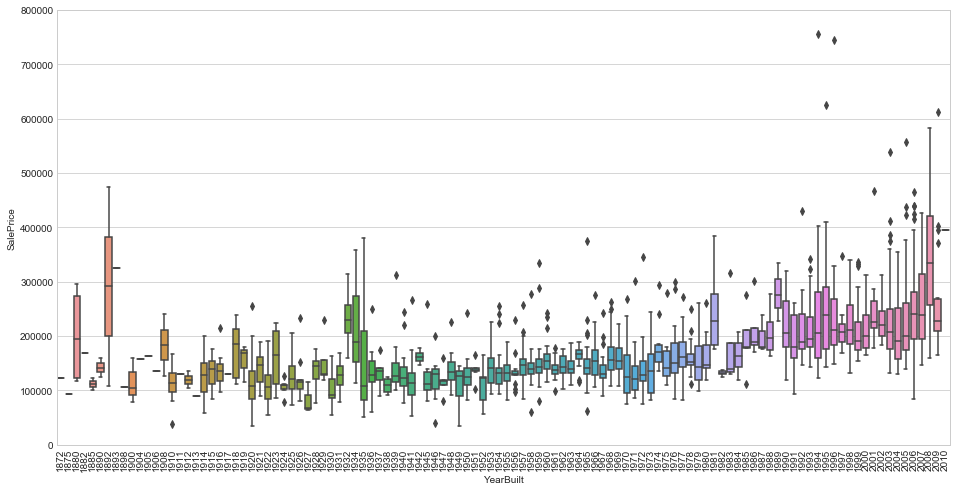

In [11]:
#box plot overallqual/YearBuilt
var = 'YearBuilt'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

'OverallQual' seems to have stronger realtionship with SalePrice than 'YearBuilt'.

#### Feature Sealection: Correltion Matrix(Heatmap style), Scatter plots between the most correlated variables

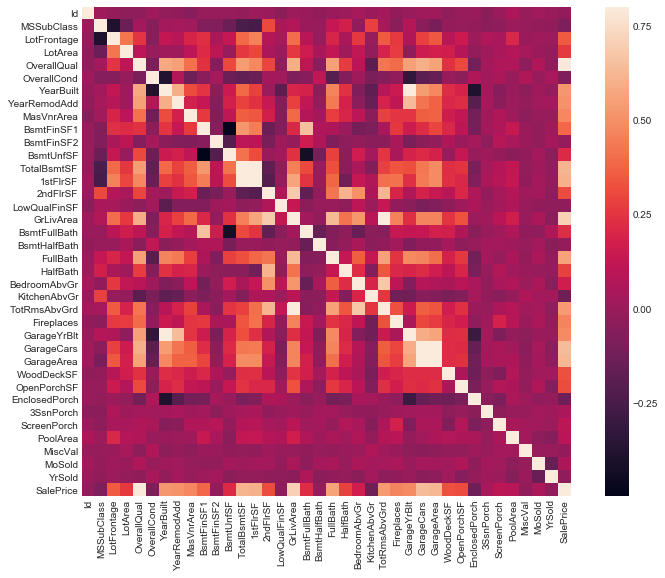

In [12]:
#Correlation matrix
corrmat = train.corr()
f, ax = plt.subplots(figsize =(12,9))
sns.heatmap(corrmat, vmax = .8, square = True);

'TotalBsmtSF and '1stFlrSF' also 'GarageX' variables has significant correlation between them as seen big white blocks in the heatmap. This indicates multicollinearity and they will end up giving almost same information.
For 'SalePrice' we can see 'GrLivArea', 'TotalBsmtSF', and 'OverallQual' are showing promising relation.

#### 'SalePrice' correlation matrix (zoomed heatmap)

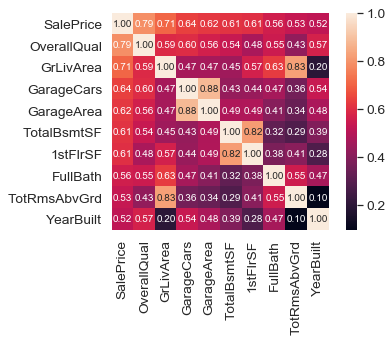

In [13]:
k= 10
cols = corrmat.nlargest(k,'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

- 'GarageCars' and 'GarageArea' seemed to be strongly correlated with 'SalePrice' along with 'OverallQual', 'GrLivArea' and 'TotalBsmtSF. But area of a garge has direct consequence on number of cars that will fit into it. So we only need one of these variables. 'GarageCars' have higher correlation so let's keep that.
- 'TotalBsmtSF' and '1stFloor' also seem to be strongly related  so we will get rid of '1stFloor'. Same with 'TotRmsAbvGrd' and 'GrLivArea. 


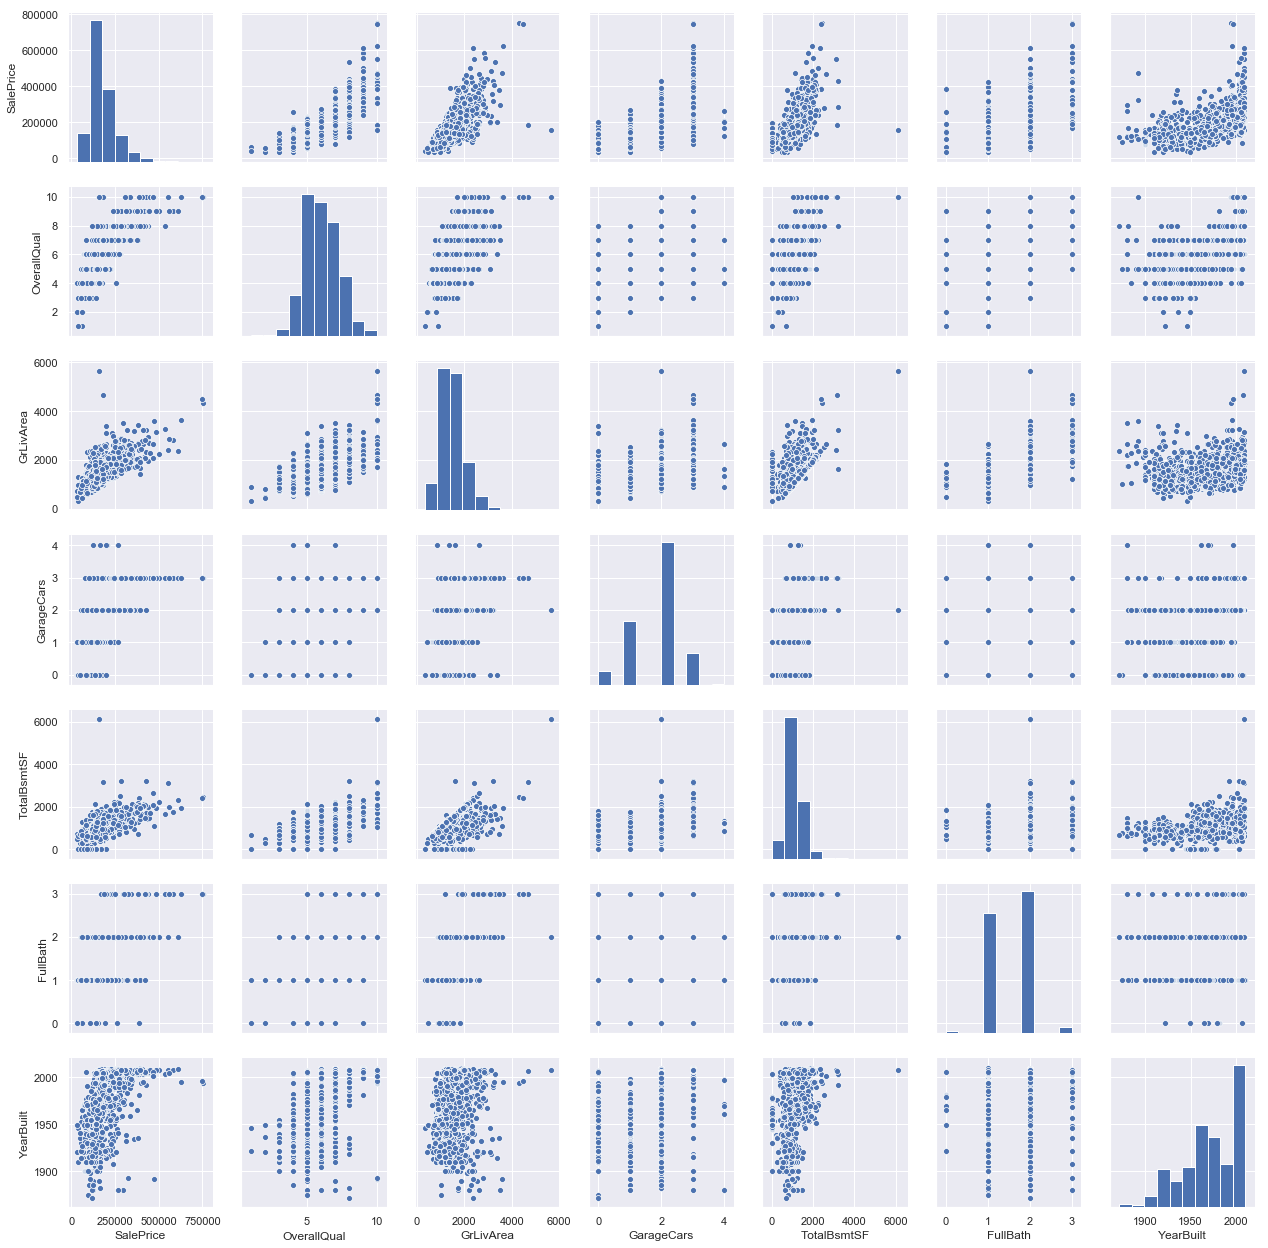

In [14]:
#scatterplots between 'SalePrice' and correlated variables 
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train[cols], size = 2.5)
plt.show();

### Handling Missing values

#### Checking for null values

In [15]:
#missing data
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


Dropping columns with missing values:

In [16]:
cols_with_missing = [col for col in train.columns if train[col].isnull().sum()>0]

reduced_train_data = train.drop(cols_with_missing, axis=1)
reduced_test_data = test.drop(cols_with_missing, axis=1)

For the variables with missing values we will delete the corresponding variable and pretend it never existed. Anyway they doesn't seem to be strong candidates so there won't be any loss.

'GarageX' and 'BsmtX' variables have same number of missing values, we will delete all the these variables except 'GarageCars' and 'TotalBsmtSF'.

'MasVnrArea' and 'MasVnrType' can also be deleted as they are not essential.

### Handling categorical data

In [17]:
one_hot_encoded_training_predictors = pd.get_dummies(reduced_train_data)
one_hot_encoded_test_predictors = pd.get_dummies(reduced_test_data)
final_train, final_test = one_hot_encoded_training_predictors.align(one_hot_encoded_test_predictors, join='left', axis=1)

In [18]:
train = final_train
test = final_test.drop(['SalePrice'], axis = 1)

### Handling Outliers

#### Univariate Analysis- "SalePrice"

In [19]:
#standardizing data
saleprice_scaled = StandardScaler().fit_transform(train['SalePrice'][:,np.newaxis])
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range= saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)                                        

outer range (low) of the distribution:
[[-1.83870376]
 [-1.83352844]
 [-1.80092766]
 [-1.78329881]
 [-1.77448439]
 [-1.62337999]
 [-1.61708398]
 [-1.58560389]
 [-1.58560389]
 [-1.5731    ]]

outer range (high) of the distribution:
[[3.82897043]
 [4.04098249]
 [4.49634819]
 [4.71041276]
 [4.73032076]
 [5.06214602]
 [5.42383959]
 [5.59185509]
 [7.10289909]
 [7.22881942]]


Low range values are around 0 but high range values are far from 0 and 7. something values are really out of range.

#### Bivariate Analysis

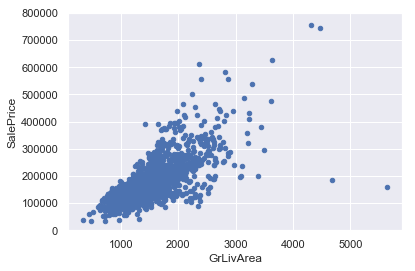

In [22]:
#bivariate analysis saleprice/grlivarea
var = 'GrLivArea'
X = pd.concat([train['SalePrice'], train[var]], axis=1)
X.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

The two observations in the top of the plot are those 7.something observations that we said we should be careful about. They look like two special cases, however they seem to be following the trend. For that reason, we will keep them.
The two values with bigger 'GrLivArea' seem strange and they are not following the crowd. We'll define them as outliers and delete them.

In [23]:
#deleting points
train.sort_values(by = 'GrLivArea', ascending = False)[:2]
train = train.drop(train[train['Id'] == 1299].index)
train = train.drop(train[train['Id'] == 524].index)

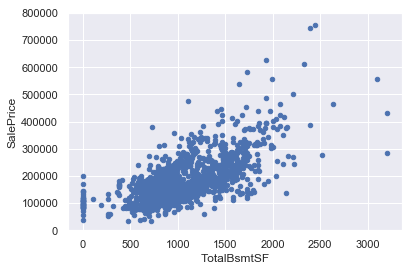

In [24]:
#bivariate analysis saleprice/grlivarea
var = 'TotalBsmtSF'
X = pd.concat([train['SalePrice'], train[var]], axis=1)
X.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

### Testing for assumptions underlying the statistical bases for multivariate analysis

1. Normality

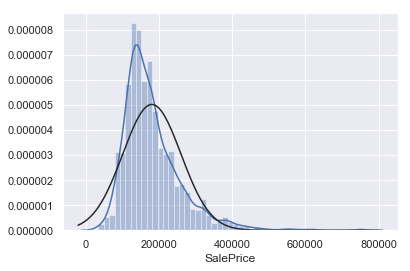

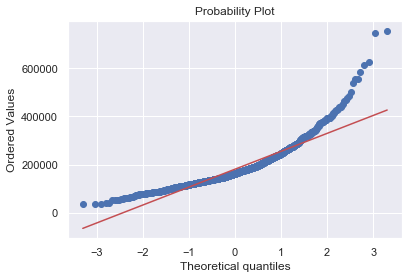

In [25]:
#histogram and normal probability plot
sns.distplot(train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)

'SalePrice' is not normal.It shows 'peakedness', positive skewness and does not follow the diagonal line. A simple data transformation can solve the problem. In case of positive skewness, log transformations usually works well.

In [26]:
#applying log transformation
train['SalePrice'] = np.log(train['SalePrice'])

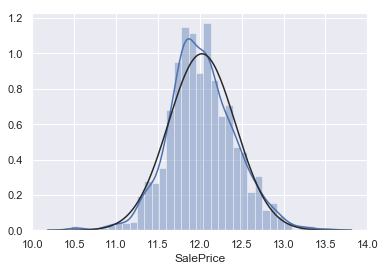

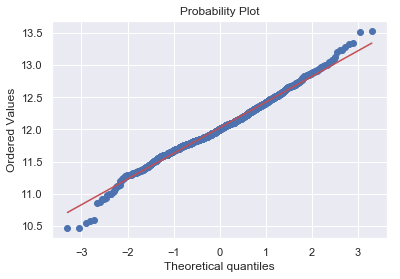

In [27]:
#transformed histogram and normal probability plot
sns.distplot(train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)

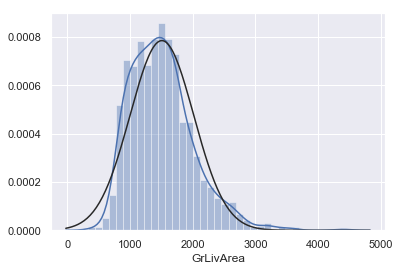

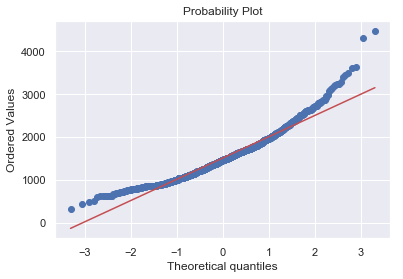

In [28]:
#histogram and normal probability plot
sns.distplot(train['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(train['GrLivArea'], plot=plt)

In [29]:
#data transformation
train['GrLivArea'] = np.log(train['GrLivArea'])

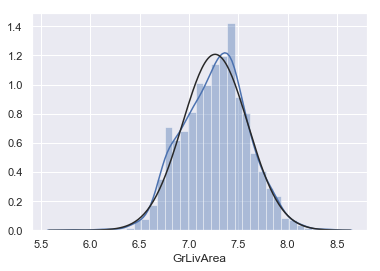

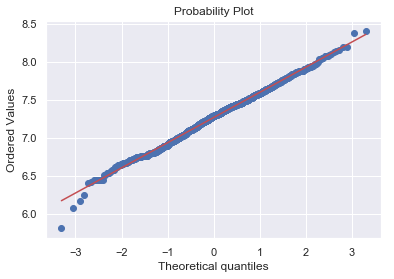

In [30]:
#transformed histogram and normal probability plot
sns.distplot(train['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(train['GrLivArea'], plot=plt)

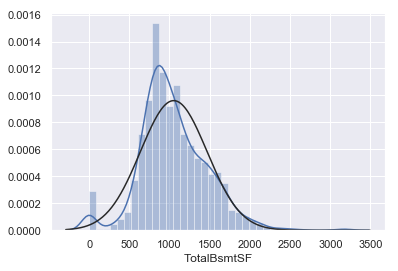

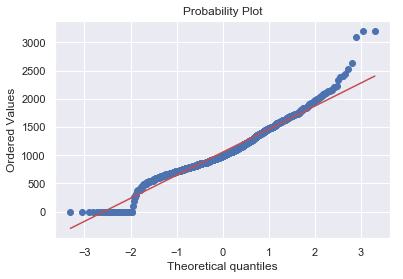

In [31]:
#histogram and normal probability plot
sns.distplot(train['TotalBsmtSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(train['TotalBsmtSF'], plot=plt)

Since lots of observations have value zero(houses without basement). But we can't log transformations with zero values. To apply a log transformation here, we'll create a variable that can get the effect of having or not having basement (binary variable). Then, we'll do a log transformation to all the non-zero observations, ignoring those with value zero. This way we can transform data, without losing the effect of having or not basement.

In [32]:
#create column for new variable (one is enough because it's a binary categorical feature)
#if area>0 it gets 1, for area==0 it gets 0
train['HasBsmt'] = pd.Series(len(train['TotalBsmtSF']), index=train.index)
train['HasBsmt'] = 0 
train.loc[train['TotalBsmtSF']>0,'HasBsmt'] = 1

In [33]:
#transform data
train.loc[train['HasBsmt']==1,'TotalBsmtSF'] = np.log(train['TotalBsmtSF'])

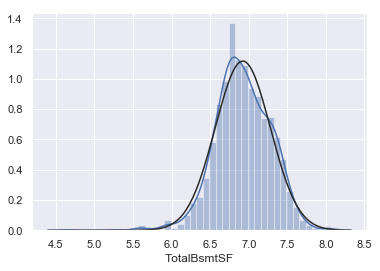

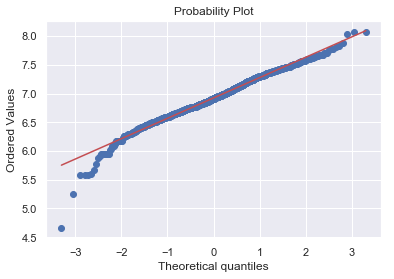

In [34]:
#histogram and normal probability plot
sns.distplot(train[train['TotalBsmtSF']>0]['TotalBsmtSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(train[train['TotalBsmtSF']>0]['TotalBsmtSF'], plot=plt)

2. Testing homoscedasticity

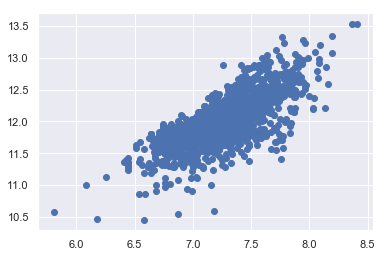

In [35]:
#scatter plot
plt.scatter(train['GrLivArea'], train['SalePrice']);

Older versions of this scatter plot (previous to log transformations), had a conic shape. As you can see, the current scatter plot doesn't have a conic shape anymore.  Just by ensuring normality in some variables, we solved the homoscedasticity problem.

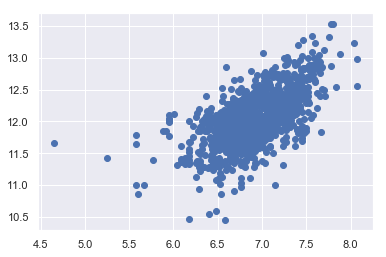

In [36]:
#scatter plot
plt.scatter(train[train['TotalBsmtSF']>0]['TotalBsmtSF'], train[train['TotalBsmtSF']>0]['SalePrice']);